# Radiated Power Analysis

In [1]:
# assume working in Jupyter Lab
%matplotlib inline 

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../pywed')
import pywed as pw
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (10,6)

from control_room import *
from pulse_database import PulseDB

import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

from scipy.optimize import curve_fit 
from tqdm import tqdm

pradwest only available on linux machines


In [3]:
# Importing Resumed Parameters
data = pd.read_csv('WEST_C4_database_resumed_parameters.csv')
data.head()

,Unnamed: 0,IC_Frequencies,IC_P_Q1,IC_P_Q2,IC_P_Q4,IC_P_tot,IC_Rc_Q1_avg,IC_Rc_Q2_avg,IC_Rc_Q4_avg,IC_Vacuum_Q1_left,...,Prad_bulk,R_Q1,R_Q2,R_Q4,Rext_median,freq_Q1,freq_Q2,freq_Q4,nl,pulse
0,0,55.5,0.0,-0.5,0.1,-0.4,0.079,0.134,1.5295,0.000170,...,-0.000583,3.0109,3.0111,3.0118,2992.12,55.5,55.689999,55.700001,0.677500,54404
1,1,55.5,0.0,-0.5,0.1,-0.4,0.079,0.134,1.5295,0.000157,...,0.030902,3.0109,3.0111,3.0118,2993.92,55.5,55.689999,55.700001,0.964195,54404
2,2,55.5,0.0,-0.5,0.1,-0.4,0.079,0.134,1.5295,0.000150,...,0.117640,3.0109,3.0111,3.0118,2947.24,55.5,55.689999,55.700001,1.185943,54404
3,3,55.5,0.0,-0.5,0.1,-0.4,0.079,0.134,1.5295,0.000127,...,0.226130,3.0109,3.0111,3.0118,2889.28,55.5,55.689999,55.700001,1.191996,54404
4,4,55.5,0.0,-0.5,0.1,-0.4,0.079,0.134,1.5295,0.000109,...,0.143420,3.0109,3.0111,3.0118,2909.92,55.5,55.689999,55.700001,1.199769,54404


In [4]:
# Define plasma configuration
data['Xpoint'] = 'LSN'
USN_list = np.r_[55227, 55174, 55173, 55172, 55171, 55170]
USN_list = np.append(USN_list, np.arange(54882, 54892))
USN_list = np.append(USN_list, np.arange(54894, 54903))
print(USN_list)
data.loc[data['pulse'].isin(USN_list), 'Xpoint'] = 'USN'

[55227 55174 55173 55172 55171 55170 54882 54883 54884 54885 54886 54887
 54888 54889 54890 54891 54894 54895 54896 54897 54898 54899 54900 54901
 54902]


## 55215

In [5]:
# keep only power larger than 200 kW
_data = data.query('pulse == 55215')
#& (LH_P_tot > 0.2 | IC_P_tot > 200) ')

In [6]:
# Radiated power fraction
_data['Ptot'] = _data['LH_P_tot'] + _data['IC_P_tot']/1e3 
# increment de puissance rayonnée par rapport à la puissance rayonnée pendant la phase ohmique
_data['ratio_Pradincr'] =  np.abs(_data['Prad'] - 0.450)/_data['Ptot']*100   # 0.45 Prad during Ohmic

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'WEST #55215')

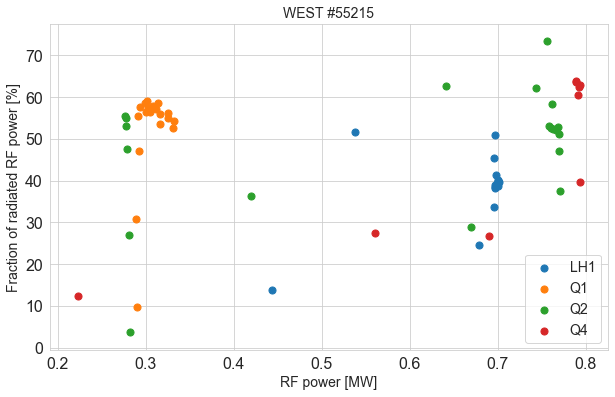

In [7]:
fig, ax = plt.subplots()
_data.query('LH_P_tot > 0.2').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='LH1', s=50)
_data.query('IC_P_Q1 > 200').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='Q1', color='C1', s=50)
_data.query('IC_P_Q2 > 200').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='Q2', color='C2', s=50)
_data.query('IC_P_Q4 > 200').plot(kind='scatter', x='Ptot', y='ratio_Pradincr', ax=ax, label='Q4', color='C3', s=50)
ax.legend(fontsize=14)
ax.set_ylabel('Fraction of radiated RF power [%]', fontsize=14)
ax.set_xlabel('RF power [MW]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST #55215', fontsize=14)

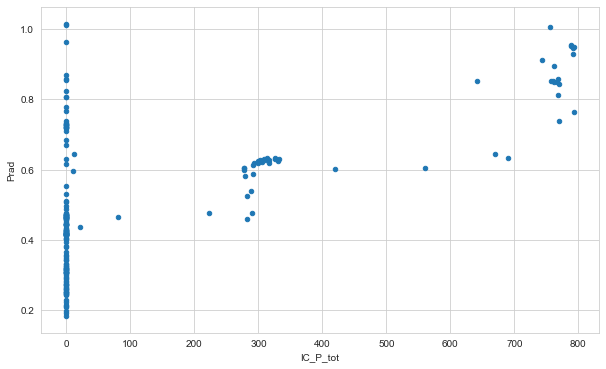

In [8]:
data.query('pulse == 55215').plot(kind='scatter', x='IC_P_tot', y='Prad')

# Coupling resistances

Text(0.5, 1.0, 'WEST #55215')

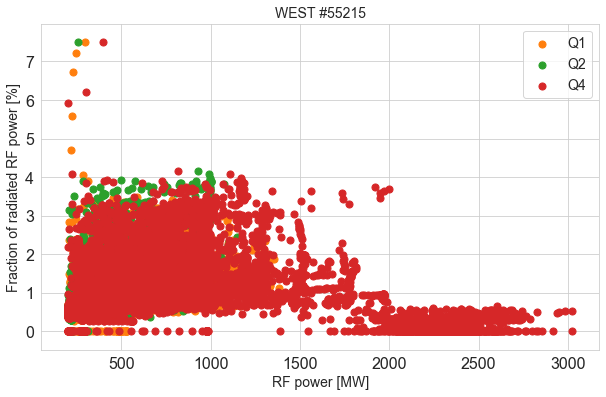

In [9]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_Q1 > 200').plot(kind='scatter', x='IC_P_Q1', y='Prad', ax=ax, label='Q1', color='C1', s=50)
data.query('IC_P_Q2 > 200').plot(kind='scatter', x='IC_P_Q2', y='Prad', ax=ax, label='Q2', color='C2', s=50)
data.query('IC_P_Q4 > 200').plot(kind='scatter', x='IC_P_Q4', y='Prad', ax=ax, label='Q4', color='C3', s=50)
ax.legend(fontsize=14)
ax.set_ylabel('Fraction of radiated RF power [%]', fontsize=14)
ax.set_xlabel('RF power [MW]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST #55215', fontsize=14)

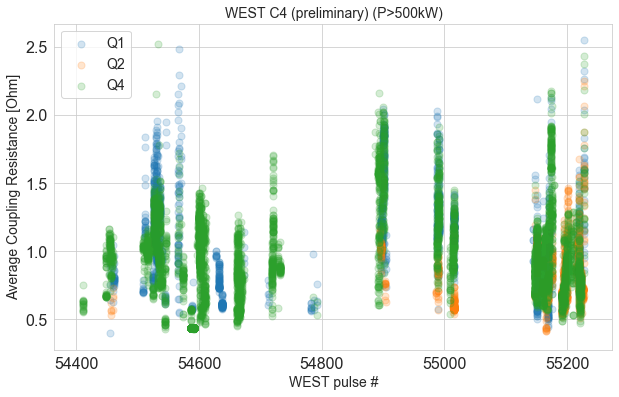

In [10]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_Q1 > 500').plot(kind='scatter', x='pulse', y='IC_Rc_Q1_avg', ax=ax, label='Q1', color='C0', s=50, alpha=0.2)
data.query('IC_P_Q2 > 500').plot(kind='scatter', x='pulse', y='IC_Rc_Q2_avg', ax=ax, label='Q2', color='C1', s=50, alpha=0.2)
data.query('IC_P_Q4 > 500').plot(kind='scatter', x='pulse', y='IC_Rc_Q4_avg', ax=ax, label='Q4', color='C2', s=50, alpha=0.2)
ax.legend(fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)

In [11]:
fig.savefig('WEST_C4_IC_Rc_vs_pulse.png', dpi=150)

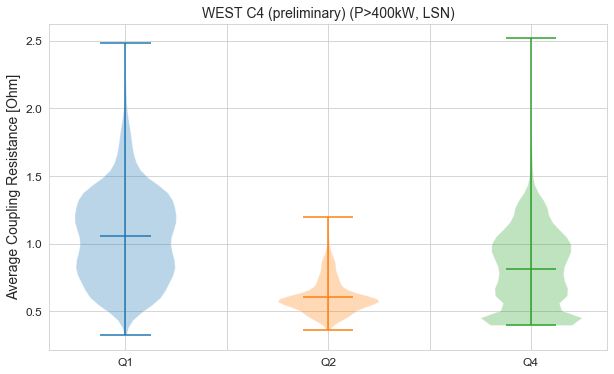

In [12]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < 55145 and Xpoint == "LSN"')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW, LSN)', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ylim = ax.set_ylim()

In [13]:
fig.savefig('WEST_C4_IC_Rc_distribution_LSN.png', dpi=150)

(0.2165972573116267, 2.62570283517337)

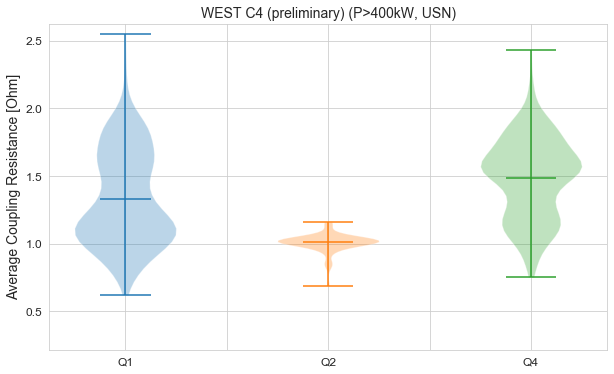

In [14]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "USN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < 55145 and Xpoint == "USN"')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "USN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW, USN)', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)

In [15]:
fig.savefig('WEST_C4_IC_Rc_distribution_USN.png', dpi=150)

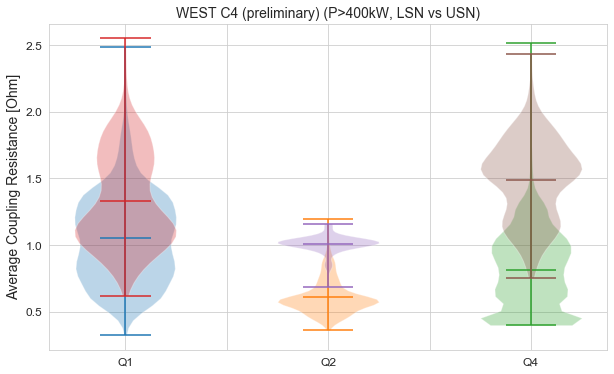

In [16]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < 55145 and Xpoint == "LSN"')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('IC_P_Q1 > 400 and Xpoint == "USN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < 55145 and Xpoint == "USN"')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and Xpoint == "USN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

#ax.legend(('Q1', 'Q2 (no.renorm.)', 'Q4'), fontsize=14)
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW, LSN vs USN)', fontsize=14)
ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ylim = ax.set_ylim()
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_vs_USN.png', dpi=150)

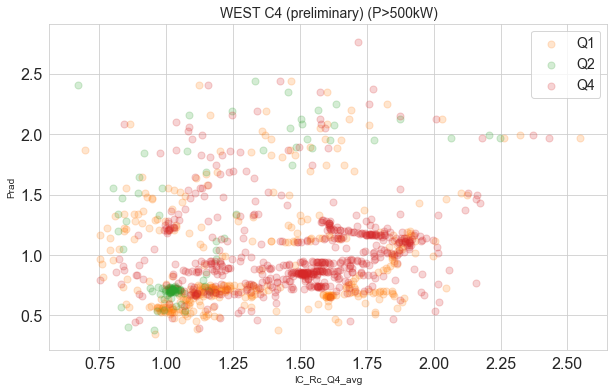

In [22]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_Q1 > 500 and Xpoint == "USN"').plot(kind='scatter', y='Prad', x='IC_Rc_Q1_avg', ax=ax, label='Q1', color='C1', s=50, alpha=0.2)
data.query('IC_P_Q2 > 500 and Xpoint == "USN"').plot(kind='scatter', y='Prad', x='IC_Rc_Q2_avg', ax=ax, label='Q2', color='C2', s=50, alpha=0.2)
data.query('IC_P_Q4 > 500 and Xpoint == "USN"').plot(kind='scatter', y='Prad', x='IC_Rc_Q4_avg', ax=ax, label='Q4', color='C3', s=50, alpha=0.2)
ax.legend(fontsize=14)
#ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
#ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)

In [65]:
# Comparaison des sessions du mardi et vendredi IC only
# mardi post-boro
mardi09_03 = [54882, 54883, 54884, 54886, 54887, 54891, 54892, 54893, 54894, 54895, 54896, 54897,
              54898, 54899, 54900, 54902, 54903, 54904]             
mardi09_10 = [55014, 55015]
mardi09_17 = [55144, 55145, 55146, 55147, 55148, 55149, 55150, 55151]
# vendredi
vendredi09_13 = [55108, 55109, 55110, 55111, 55112, 55113, 55114]
vendredi09_20 = [55223, 55224, 55225, 55226, 55227]

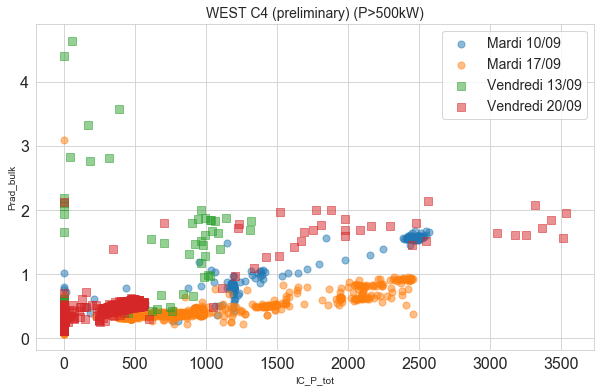

In [46]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_tot >= 0 and pulse in @mardi09_10').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Mardi 10/09', color='C0', s=50, alpha=0.5)
data.query('IC_P_tot >= 0 and pulse in @mardi09_17').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Mardi 17/09', color='C1', s=50, alpha=0.5)

data.query('IC_P_tot >= 0 and pulse in @vendredi09_13').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Vendredi 13/09', color='C2', s=50, marker='s', alpha=0.5)
data.query('IC_P_tot >= 0 and pulse in @vendredi09_20').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot', 
                                                          ax=ax, label='Vendredi 20/09', color='C3', s=50, marker='s', alpha=0.5)

ax.legend(fontsize=14)
#ax.set_ylabel('Average Coupling Resistance [Ohm]', fontsize=14)
#ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)

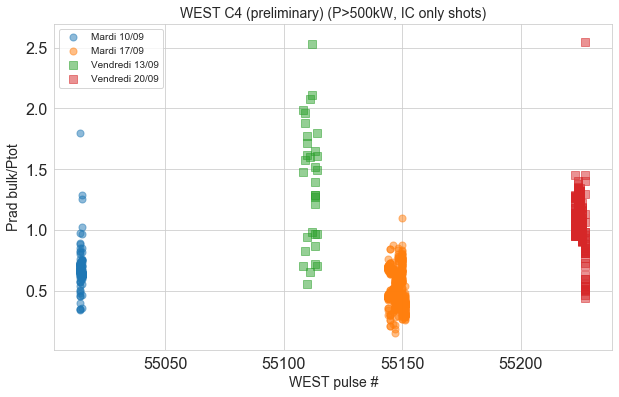

In [47]:
data['PradBulkMinusICtot'] = ( data['Prad_bulk']*1e3)/data['IC_P_tot']

fig, ax = plt.subplots()
data.query('IC_P_tot >= 400 and pulse in @mardi09_10').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Mardi 10/09', color='C0', s=50, alpha=0.5)
data.query('IC_P_tot >= 400 and pulse in @mardi09_17').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Mardi 17/09', color='C1', s=50, alpha=0.5)

data.query('IC_P_tot >= 400 and pulse in @vendredi09_13').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Vendredi 13/09', color='C2', s=50, marker='s', alpha=0.5)
data.query('IC_P_tot >= 400 and pulse in @vendredi09_20').plot(kind='scatter', y='PradBulkMinusICtot', x='pulse', 
                                                          ax=ax, label='Vendredi 20/09', color='C3', s=50, marker='s', alpha=0.5)


ax.set_ylabel('Prad bulk/Ptot', fontsize=14)
ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW, IC only shots)', fontsize=14)
ax.grid(True)

In [48]:
fig.savefig('WEST_C4_Prad1.png', dpi=150)

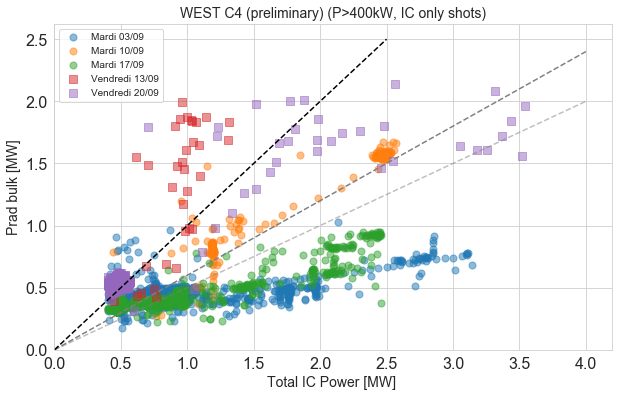

In [71]:
data['PradBulkMinusICtot'] = ( data['Prad_bulk']*1e3)/data['IC_P_tot']
data['IC_P_tot_MW'] = data['IC_P_tot']/1e3

fig, ax = plt.subplots()
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @mardi09_03').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Mardi 03/09', color='C0', s=50, alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @mardi09_10').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Mardi 10/09', color='C1', s=50, alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @mardi09_17').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Mardi 17/09', color='C2', s=50, alpha=0.5)

data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @vendredi09_13').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Vendredi 13/09', color='C3', s=50, marker='s', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_tot >= 400 and pulse in @vendredi09_20').plot(kind='scatter', y='Prad_bulk', x='IC_P_tot_MW', 
                                                          ax=ax, label='Vendredi 20/09', color='C4', s=50, marker='s', alpha=0.5)

ax.plot([0,4], [0,0.5*4], ls='--', c='grey', alpha=0.5)
ax.plot([0,4], [0,0.6*4], ls='--', c='grey')
ax.plot([0,2.5], [0,2.5], ls='--', c='k')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.set_ylabel('Prad bulk [MW]', fontsize=14)
ax.set_xlabel('Total IC Power [MW] ', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>400kW, IC only shots)', fontsize=14)
ax.grid(True)
fig.savefig('WEST_C4_impact_boro.png', dpi=150)

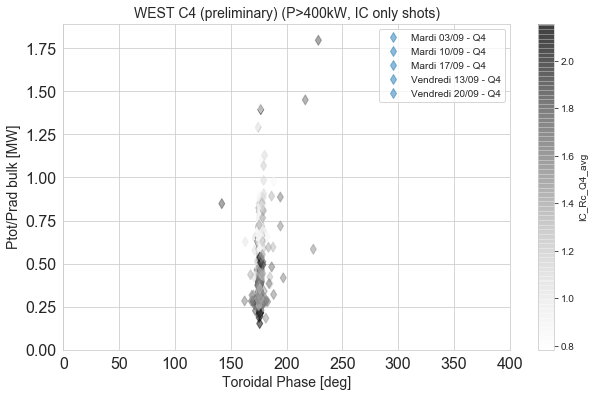

In [95]:
fig, ax = plt.subplots()



data.query('LH_P_tot < 0.1 and IC_P_Q4 >= 400 and pulse in @mardi09_03').plot(kind='scatter', y='PradBulkMinusICtot', 
                                                          x='IC_delta_phi_toro_Q4_Top_LmR', colorbar=True,
                                                          ax=ax, label='Mardi 03/09 - Q4', c='IC_Rc_Q4_avg', s=50, marker='d', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_Q4 >= 400 and pulse in @mardi09_10').plot(kind='scatter', y='PradBulkMinusICtot', 
                                                          x='IC_delta_phi_toro_Q4_Top_LmR', colorbar=False,
                                                          ax=ax, label='Mardi 10/09 - Q4', c='IC_Rc_Q4_avg', s=50, marker='d', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_Q4 >= 400 and pulse in @mardi09_17').plot(kind='scatter', y='PradBulkMinusICtot', 
                                                          x='IC_delta_phi_toro_Q4_Top_LmR', colorbar=False,
                                                          ax=ax, label='Mardi 17/09 - Q4', c='IC_Rc_Q4_avg', s=50, marker='d', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_Q4 >= 400 and pulse in @vendredi09_13').plot(kind='scatter', y='PradBulkMinusICtot', 
                                                          x='IC_delta_phi_toro_Q4_Top_LmR', colorbar=False,
                                                          ax=ax, label='Vendredi 13/09 - Q4', c='IC_Rc_Q4_avg', s=50, marker='d', alpha=0.5)
data.query('LH_P_tot < 0.1 and IC_P_Q4 >= 400 and pulse in @vendredi09_20').plot(kind='scatter', y='PradBulkMinusICtot', 
                                                          x='IC_delta_phi_toro_Q4_Top_LmR', colorbar=False,
                                                          ax=ax, label='Vendredi 20/09 - Q4', c='IC_Rc_Q4_avg', s=50, marker='d', alpha=0.5)



ax.set_xlim(0,400)
ax.set_ylim(bottom=0)
ax.set_ylabel('Ptot/Prad bulk [MW]', fontsize=14)
ax.set_xlabel('Toroidal Phase [deg]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>400kW, IC only shots)', fontsize=14)
ax.grid(True)

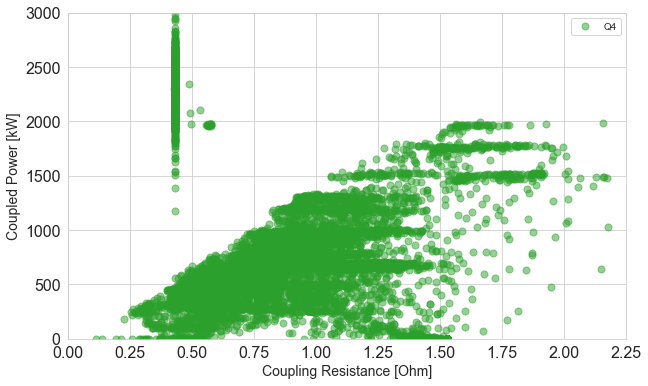

In [127]:
fig, ax = plt.subplots()

data.plot(kind='scatter', y='IC_P_Q4', 
                                                     x='IC_Rc_Q4_avg', 
                                                     ax=ax, label='Q4', color="C2", s=50, alpha=0.5)
ax.set_xlim(0, 2.25)
ax.set_ylim(0, 3.0e3)
ax.set_xlabel('Coupling Resistance [Ohm]', fontsize=14)
ax.set_ylabel('Coupled Power [kW]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
fig.savefig('WEST_C4_Q4_Rc_vs_P.png', dpi=150)

# Phasing

In [ ]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('IC_P_Q1 > 500').plot(kind='scatter', x='pulse', y='IC_delta_phi_toro_Q1_Bot_LmR', 
                                 ax=ax, label='Q1', color='C0', s=50, alpha=0.2)
data.query('IC_P_Q2 > 500').plot(kind='scatter', x='pulse', y='IC_delta_phi_toro_Q2_Top_LmR', 
                                 ax=ax, label='Q2', color='C1', s=50, alpha=0.2)
data.query('IC_P_Q4 > 500').plot(kind='scatter', x='pulse', y='IC_delta_phi_toro_Q4_Top_LmR', 
                                 ax=ax, label='Q4', color='C2', s=50, alpha=0.2)
ax.legend(fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)

In [ ]:
fig.savefig('WEST_C4_IC_phase_toro.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
ax.violinplot(data.query('IC_P_Q1 > 400 ')['IC_delta_phi_toro_Q1_Bot_LmR'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 ')['IC_delta_phi_toro_Q2_Top_LmR'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 ')['IC_delta_phi_toro_Q4_Top_LmR'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)
fig.savefig('WEST_C4_IC_Phase_toro_distribution.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
pulse_ref = 54626
ax.violinplot(data.query('IC_P_Q1 > 400 and pulse < @pulse_ref')['IC_delta_phi_toro_Q1_Bot_LmR'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse < @pulse_ref')['IC_delta_phi_toro_Q2_Top_LmR'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and pulse < @pulse_ref')['IC_delta_phi_toro_Q4_Top_LmR'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW, before phase control)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)
ax.set_ylim(0,360)
fig.savefig('WEST_C4_IC_Phase_toro_distribution_before_control.png', dpi=150)

In [ ]:
fig, ax = plt.subplots()
pulse_ref = 54626
ax.violinplot(data.query('IC_P_Q1 > 400 and pulse > @pulse_ref')['IC_delta_phi_toro_Q1_Bot_LmR'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q2 > 400 and pulse > @pulse_ref')['IC_delta_phi_toro_Q2_Top_LmR'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('IC_P_Q4 > 400 and pulse > @pulse_ref')['IC_delta_phi_toro_Q4_Top_LmR'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P>400kW, after phase control)', fontsize=14)
ax.grid(True)
ax.axhline(180, color='k', ls='--', alpha=0.8)
ax.set_ylim(0,360)
fig.savefig('WEST_C4_IC_Phase_toro_distribution_after_control.png', dpi=150)

# LH and IC

In [ ]:
_pulses = [55215, 55216]

fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.query('pulse == 55214').plot(kind='scatter', x='LH_P_tot', y='IC_Rc_Q2_avg', 
                                 ax=ax, label='Q1', color='C0', s=50, alpha=0.2)
data.query('pulse == 55215').plot(kind='scatter', x='LH_P_tot', y='IC_Rc_Q2_avg', 
                                 ax=ax, label='Q1', color='C1', s=50, alpha=0.2)

ax.legend(fontsize=14)
#ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
#ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)

In [ ]:
fig, ax = plt.subplots()
#data.query('LH_P_tot > 0.2').plot(kind='scatter', x='P', y='Prad', ax=ax, label='LH1', s=50)
data.plot(kind='scatter', x='pulse', y='IC_P_tot', 
                                 ax=ax, label='P_IC', color='C0', s=50, alpha=0.2)

ax.legend(fontsize=14)
#ax.set_ylabel('Toroidal phase between strap [deg]', fontsize=14)
#ax.set_xlabel('WEST pulse #', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_title('WEST C4 (preliminary) (P>500kW)', fontsize=14)
ax.grid(True)
ax.set_ylim(bottom=0)
fig.savefig('WEST_C4_P_IC_tot.png', dpi=150)

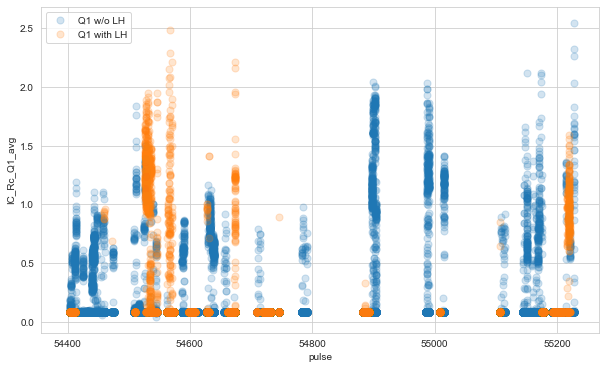

In [42]:
fig, ax = plt.subplots()
data.query('LH_P_tot < 0.1').plot(kind='scatter', x='pulse', y='IC_Rc_Q1_avg', 
                                 ax=ax, label='Q1 w/o LH', color='C0', s=50, alpha=0.2)
data.query('LH_P_tot > 0.4').plot(kind='scatter', x='pulse', y='IC_Rc_Q1_avg', 
                                 ax=ax, label='Q1 with LH', color='C1', s=50, alpha=0.2)

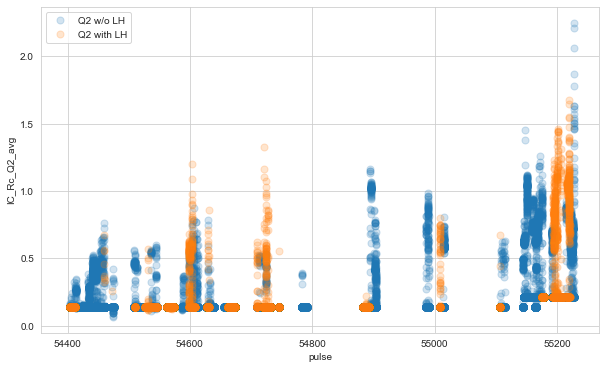

In [41]:
fig, ax = plt.subplots()
data.query('LH_P_tot < 0.1').plot(kind='scatter', x='pulse', y='IC_Rc_Q2_avg', 
                                 ax=ax, label='Q2 w/o LH', color='C0', s=50, alpha=0.2)
data.query('LH_P_tot > 0.4').plot(kind='scatter', x='pulse', y='IC_Rc_Q2_avg', 
                                 ax=ax, label='Q2 with LH', color='C1', s=50, alpha=0.2)

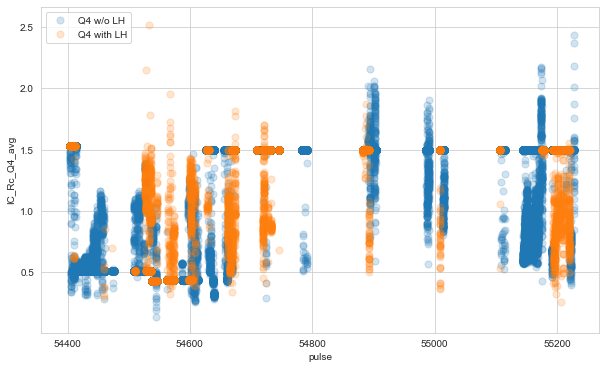

In [43]:
fig, ax = plt.subplots()
data.query('LH_P_tot < 0.1').plot(kind='scatter', x='pulse', y='IC_Rc_Q4_avg', 
                                 ax=ax, label='Q4 w/o LH', color='C0', s=50, alpha=0.2)
data.query('LH_P_tot > 0.4').plot(kind='scatter', x='pulse', y='IC_Rc_Q4_avg', 
                                 ax=ax, label='Q4 with LH', color='C1', s=50, alpha=0.2)

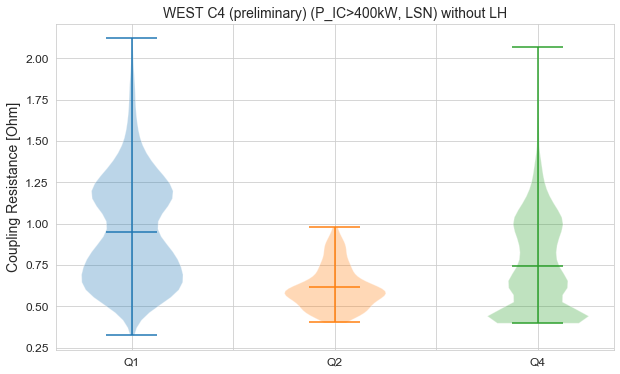

In [34]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) without LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ylim = ax.set_ylim()
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_wo_LH.png', dpi=150)

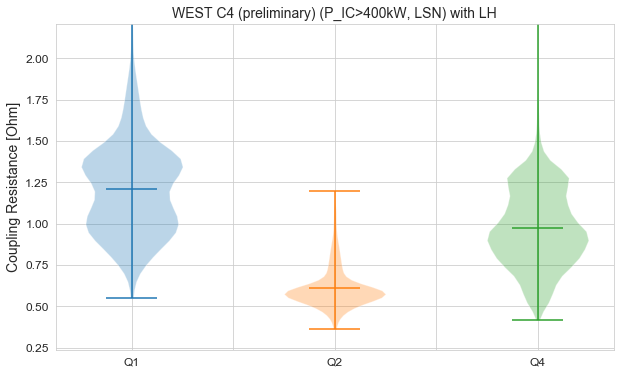

In [35]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) with LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_w_LH.png', dpi=150)

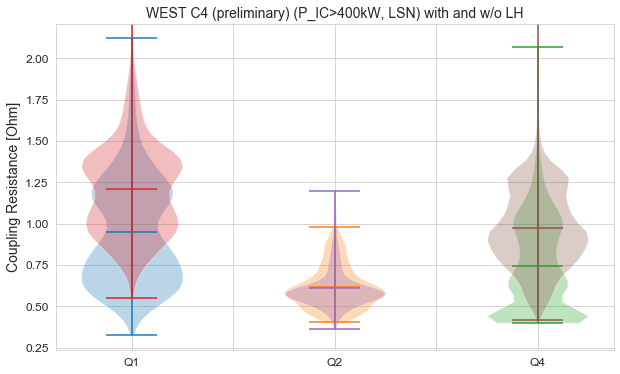

In [36]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse < 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) with and w/o LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_w-and-wo_LH.png', dpi=150)

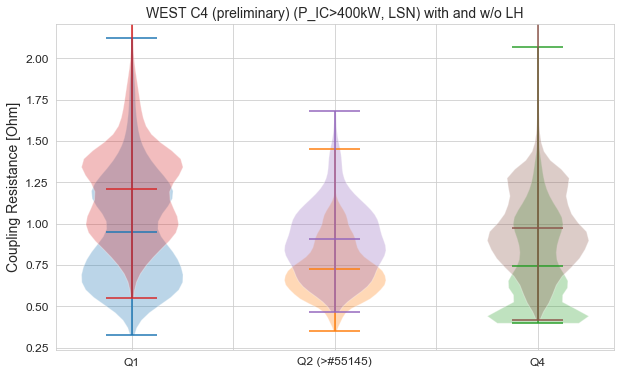

In [38]:
fig, ax = plt.subplots()
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse > 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot < 0.1 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')

ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q1 > 400 and Xpoint == "LSN"')['IC_Rc_Q1_avg'].dropna(), [0], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q2 > 400 and Xpoint == "LSN" and pulse > 55145')['IC_Rc_Q2_avg'].dropna(), [1], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.violinplot(data.query('LH_P_tot > 0.5 and IC_P_Q4 > 400 and Xpoint == "LSN"')['IC_Rc_Q4_avg'].dropna(), [2], points=40, widths=0.5,
                      showmeans=True, showextrema=True, 
                      bw_method='silverman')
ax.set_xticklabels(('', 'Q1', '', 'Q2 (>#55145)', '', 'Q4'), fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('WEST C4 (preliminary) (P_IC>400kW, LSN) with and w/o LH', fontsize=14)
ax.set_ylabel('Coupling Resistance [Ohm]', fontsize=14)
ax.grid(True)
ax.set_ylim(ylim)
fig.savefig('WEST_C4_IC_Rc_distribution_LSN_w-and-wo_LH.png', dpi=150)